Building a RAG application from scratch
Here is a high-level overview of the system we want to build:


# This is the kafka kraft Langchain Rag tutorial from youtube video/audio transcript.
YOUTUBE_VIDEO = ""

Setting up the model
Let's define the LLM model that we'll use as part of the workflow.

In [20]:
from langchain_openai.chat_models import ChatOpenAI

#Instruct lab Granite Model and API configuration
MODEL_SERVICE = "http://localhost:33665/v1"
API_KEY = "sk-no-key-required"

model = ChatOpenAI(base_url=MODEL_SERVICE, api_key=API_KEY, streaming=True, max_tokens=4096)


In [21]:
model.invoke("What is kafka kraft")

AIMessage(content='Apologies for the confusion, but I was unable to find any information related to "kafka kraft" in my knowledge base. It\'s possible that this term may be misspelled or unrelated to the topic you\'re interested in. Could you please provide more context or details about the term? This will help me give you a more accurate and helpful response.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo'}, id='run-2e62d8d2-b3ab-410d-ba8d-a9ba2379a4bd-0')

![chain1](images/chain1.png)

In [22]:
# For this example, we'll use a simple StrOutputParser to extract the answer as a string.
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()
chain = model | parser
chain.invoke("What is kafka kraft?")

'Kafka Kraft is actually the name of a popular open-source streaming platform that is based on the Apache Kafka technology. It is used for building real-time data pipelines and streaming applications. It provides features such as fault tolerance, scalability, and high throughput, making it suitable for handling large volumes of data and heavy loads.'

Introducing prompt templates
We want to provide the model with some context and the question. Prompt templates are a simple way to define and reuse prompts.

In [23]:
from langchain.prompts import ChatPromptTemplate

template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt.format(context="KRaft, or Apache Kafka Raft, is a consensus protocol that allows Kafka to manage metadata without relying on ZooKeeper", 
              question="What is kafka kraft?")

'Human: \nAnswer the question based on the context below. If you can\'t \nanswer the question, reply "I don\'t know".\n\nContext: KRaft, or Apache Kafka Raft, is a consensus protocol that allows Kafka to manage metadata without relying on ZooKeeper\n\nQuestion: What is kafka kraft?\n'

![chain2](images/chain2.png)

In [24]:
chain = prompt | model | parser
chain.invoke({
    "context": "KRaft, or Apache Kafka Raft, is a consensus protocol that allows Kafka to manage metadata without relying on ZooKeeper",
    "question": "What is kafka kraft?"
})

"Kafka Raft, or KRaft, is a consensus protocol used by the Kafka distributed system to manage metadata without relying on ZooKeeper. It's a crucial component in Kafka's architecture, enabling the system to function effectively and maintain consistency in the face of network partitions and other challenges. I'm glad you found the information helpful! If you have any more questions about Kafka Raft or other computer science topics, please don't hesitate to ask. "

Combining chains
We can combine different chains to create more complex workflows. For example, let's create a second chain that translates the answer from the first chain into a different language.

Let's start by creating a new prompt template for the translation chain:

In [25]:
#  language translation model
# https://huggingface.co/webbigdata/C3TR-Adapter_gguf?show_file_info=C3TR-Adapter-Q4_k_m.gguf --- deployed on podman desktop

# Model and API configuration
MODEL_SERVICE_2 = "http://localhost:46445/v1"
API_KEY_2 = "sk-no-key-required"

model_2 = ChatOpenAI(base_url=MODEL_SERVICE_2, api_key=API_KEY_2, streaming=True)


In [26]:
translation_prompt = ChatPromptTemplate.from_template(
    "Translate {answer} to {language}"
)

![chain3](images/chain3.png)


In [27]:
from operator import itemgetter

translation_chain = (
    {"answer": chain, "language": itemgetter("language")} | translation_prompt | model_2 | parser
)

translation_chain.invoke(
    {
        "context": "KRaft improves Kafka’s scalability by reducing the load on the metadata store. In KRaft mode, only the controller quorum (a subset of brokers) participates in the Raft protocol, while the rest of the brokers only communicate with the controller quorum. This reduces the number of connections and requests that have to go through the metadata store, and allows Kafka to handle more brokers and topics without affecting the performance and availability of the metadata store",
        "question": "In KRaft mode who participates in raft protocol?",
        "language": "french",
    }
)

" </s>\n\nIn KRaft mode, seuls les quorum de contrôleurs (un sous-ensemble de brokers) participent au protocole Raft. Il s'agit d'une modification par rapport à la méthode d'élection du leader originale de Kafka, où tous les brokers devaient participer au protocole Raft. En limitant le nombre de brokers qui participent au protocole Raft, le mode KRaft réduit la charge sur le magasin de métadonnées et permet à Kafka de gérer plus de brokers et de sujets sans affecter négativement les performances et la disponibilité du magasin de métadonnées."

Transcribing the YouTube Video
The context we want to send the model comes from a YouTube video. Let's download the video and transcribe it using OpenAI's Whisper.
https://huggingface.co/openai/whisper-base

In [47]:
!pip install pytubefix
import os
#from pytube import YouTube
from moviepy.editor import *
from pytubefix import YouTube
from pytubefix.cli import on_progress
import tempfile

from transformers import WhisperProcessor, WhisperForConditionalGeneration

# 
# Enter the YouTube video URL kafka kraft vs zookeeper video
url = "https://www.youtube.com/watch?v=6YL0L4lb9iM&t=323s"

# Download the video
yt = YouTube(url, on_progress_callback = on_progress)
print(yt.title)
stream = yt.streams.get_highest_resolution()
stream.download()

# Extract the audio
video = VideoFileClip('KRaft.mp4')
audio = video.audio
audio.write_audiofile('KRaft.mp3')

# Delete the downloaded video file
#os.remove('KRaft.mp4')
 



The Apache Kafka® Control Plane – ZooKeeper vs. KRaft
MoviePy - Writing audio in ZooKeeper_KRaft.mp3


MoviePy - Done.


In [48]:
# load openai/whisper model and processor: https://huggingface.co/openai/whisper-large-v3-turbo
! pip install librosa soundfile
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
model_id = "openai/whisper-large-v3-turbo"

whisper_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
whisper_model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=whisper_model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)
#dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")
#sample = dataset[0]["audio"]

result = pipe('KRaft.mp3')
print(result["text"])

with open("KRaft_transcription.txt", "w") as file:
            file.write(result["text"])


 Hi everyone, welcome back. This is Jun from Confluent. In this module, we're going to talk about the Kafka's control plane. In the previous module, we have talked about a data plane and how the client requests and the replications handled through the data plane. And in this module, we are going to talk about control plane, which manages the metadata of the cluster. The old way of managing the control plane is through ZooKeeper. there is like one broker is picked as a special controller, and the controller is responsible for managing and changing the metadata of the whole cluster. The metadata is persisted in the consensus service, which is the external cap that is called ZooKeeper. And the controller is also responsible for propagating the metadata changes to the rest of the broker. The new world of the control plane is implemented through a new module called KRAFT. Since we completely eliminated the dependency on Zookeeper, instead we have a built-in consensus service based on RAFT w

In [28]:
# Let's do this only if we haven't created the transcription of kafka kraft file yet.
import os
if os.path.exists("KRaft_transcription.txt"):
    
  with open("KRaft_transcription.txt") as file:
    transcription = file.read().strip()

transcription[:208]

"Hi everyone, welcome back. This is Jun from Confluent. In this module, we're going to talk about the Kafka's control plane. In the previous module, we have talked about a data plane and how the client request"

Using the entire transcription as context
If we try to invoke the chain using the transcription as context, the model will return an error because the context is too long.

Large Language Models support limitted context sizes. The video we are using is too long for the model to handle, so we need to find a different solution.

In [29]:
try:
    chain.invoke({
        "context": transcription,
        "question": "what benefits kraft provides over zookeeper?"
    })
except Exception as e:
    print(e)

Error code: 400 - {'error': {'message': "This model's maximum context length is 2048 tokens. However, you requested 6639 tokens (2543 in the messages, 4096 in the completion). Please reduce the length of the messages or completion.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


Splitting the transcription
Since we can't use the entire transcription as the context for the model, a potential solution is to split the transcription into smaller chunks. We can then invoke the model using only the relevant chunks to answer a particular question:

![system2](images/system2.png)


Let's start by loading the transcription in memory:

In [30]:
#!pip install langchain_community
from langchain_community.document_loaders import TextLoader

loader = TextLoader("KRaft_transcription.txt")
text_documents = loader.load()
text_documents

[Document(metadata={'source': 'KRaft_transcription.txt'}, page_content=" Hi everyone, welcome back. This is Jun from Confluent. In this module, we're going to talk about the Kafka's control plane. In the previous module, we have talked about a data plane and how the client requests and the replications handled through the data plane. And in this module, we are going to talk about control plane, which manages the metadata of the cluster.\n \nThe old way of managing the control plane is through ZooKeeper. there is like one broker is picked as a special controller, and the controller is responsible for managing and changing the metadata of the whole cluster. The metadata is persisted in the consensus service, which is the external cap that is called ZooKeeper.\n \nAnd the controller is also responsible for propagating the metadata changes to the rest of the broker. The new world of the control plane is implemented through a new module called KRAFT. Since we completely eliminated the depen

let's split the transcription into chunks of 100 characters with an overlap of 20 characters and display the first few chunks:

In [32]:
# For our specific application, let's use 1030 characters instead:
from langchain_text_splitters import CharacterTextSplitter
text_splitter = CharacterTextSplitter(chunk_size=1030, chunk_overlap=0)
texts = text_splitter.split_documents(text_documents)


Finding the relevant chunks
Given a particular question, we need to find the relevant chunks from the transcription to send to the model. Here is where the idea of embeddings comes into play.

An embedding is a mathematical representation of the semantic meaning of a word, sentence, or document. It's a projection of a concept in a high-dimensional space. Embeddings have a simple characteristic: The projection of related concepts will be close to each other, while concepts with different meanings will lie far away. You can use the Cohere's Embed Playground to visualize embeddings in two dimensions.

To provide with the most relevant chunks, we can use the embeddings of the question and the chunks of the transcription to compute the similarity between them. We can then select the chunks with the highest similarity to the question and use them as the context for the model:

![system3](images/system3.png)

In [41]:
# Let's generate embeddings for an arbitrary query:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
embedded_query = embeddings.embed_query("What is kafka kraft ?")

print(f"Embedding length: {len(embedded_query)}")
print(embedded_query[:10])

Embedding length: 384
[-0.07865618914365768, -0.022692644968628883, -0.10701049119234085, 0.07006821781396866, -0.018506599590182304, 0.010291829705238342, -0.03405401110649109, 0.03180241212248802, 0.04199271649122238, -0.034716539084911346]


We can now compute the similarity between the query and each of the two sentences. The closer the embeddings are, the more similar the sentences will be.

We can use Cosine Similarity to calculate the similarity between the query and each of the sentences:

Setting up a Vector Store
We need an efficient way to store document chunks, their embeddings, and perform similarity searches at scale. To do this, we'll use a vector store.

A vector store is a database of embeddings that specializes in fast similarity searches.

![system4](images/system4.png)

To understand how a vector store works, let's create one in memory and add a few embeddings to it:

In [34]:
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore1 = DocArrayInMemorySearch.from_texts(
    [
        "with kraft model we can achieve at least 10x scalability improvements in terms the amount of metadata it can handle within a cluster",
        "kraft model also allows the metadata to be propagated from the controller to the brokers in a much more efficient way",
        "kraft  makes the operation of kaka a lot easier by removing the number of moving parts",
        "In the k-wrap mode all the metadata record has to be persisted in the log it has to be flushed to disk before they are exposed",
        "in the k-raft mode let's say in this case the older leader on controller one failed and then we would need to elect a new leader in this case since there's no concept isr the remaining replicas controller 2 and 3 need to coordinate among themselves to select a new leader",    
    ],
    embedding=embeddings,
)

/home/kkakarla/Development/git-projects/venv/lib64/python3.11/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


We can now query the vector store to find the most similar embeddings to a given query:

In [35]:
vectorstore1.similarity_search_with_score(query="What is kraft?", k=3)

[(Document(page_content='kraft  makes the operation of kaka a lot easier by removing the number of moving parts'),
  0.5419106076998392),
 (Document(page_content='kraft model also allows the metadata to be propagated from the controller to the brokers in a much more efficient way'),
  0.4914185122176974),
 (Document(page_content='with kraft model we can achieve at least 10x scalability improvements in terms the amount of metadata it can handle within a cluster'),
  0.4385470253110965)]

Connecting the vector store to the chain
We can use the vector store to find the most relevant chunks from the transcription to send to the model. Here is how we can connect the vector store to the chain:
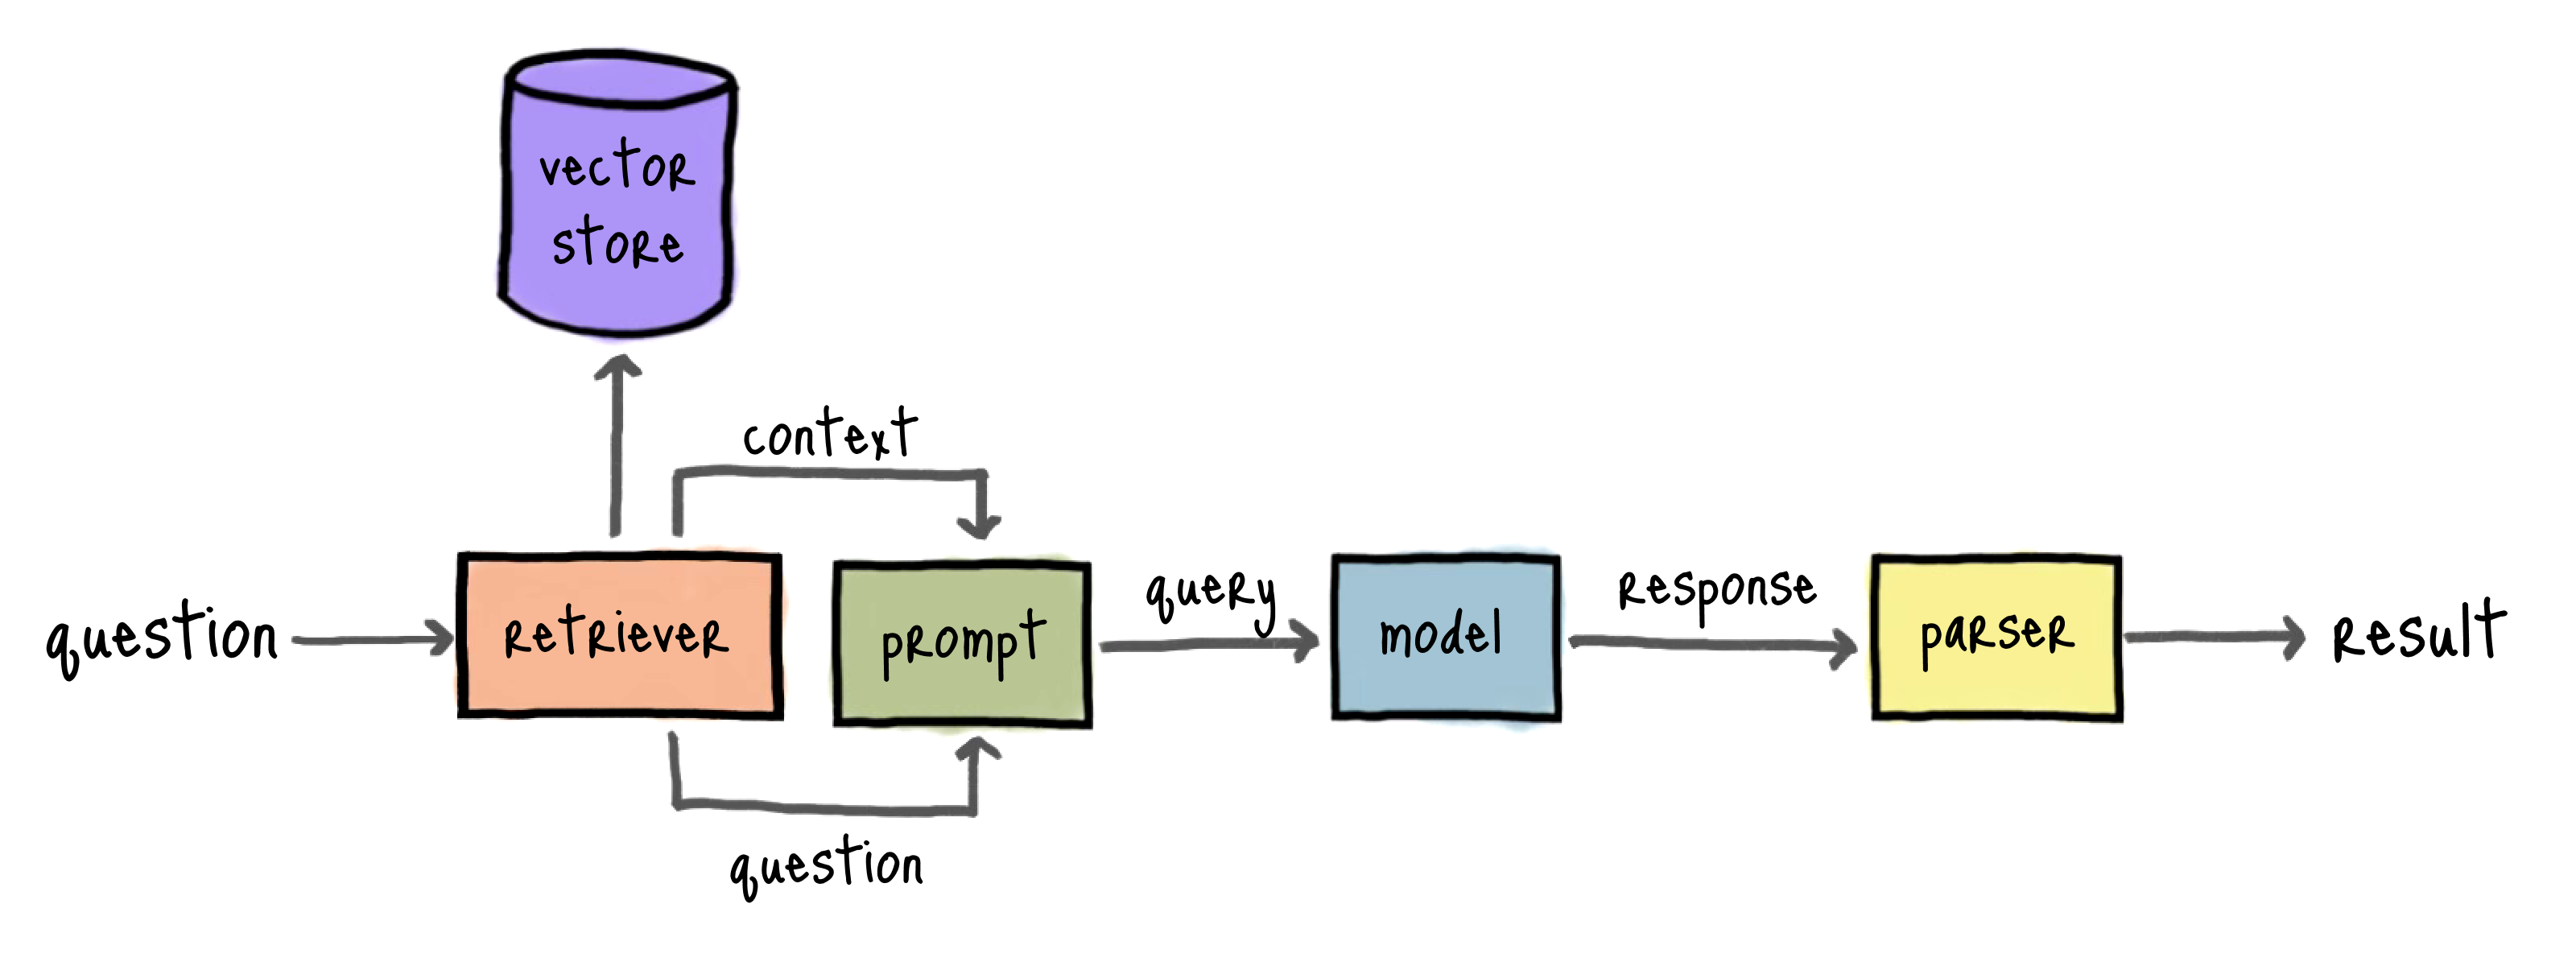

We need to configure a Retriever. The retriever will run a similarity search in the vector store and return the most similar documents back to the next step in the chain.

We can get a retriever directly from the vector store we created before:

In [36]:
retriever1 = vectorstore1.as_retriever()
retriever1.invoke("What is kraft?")

[Document(page_content='kraft  makes the operation of kaka a lot easier by removing the number of moving parts'),
 Document(page_content='kraft model also allows the metadata to be propagated from the controller to the brokers in a much more efficient way'),
 Document(page_content='with kraft model we can achieve at least 10x scalability improvements in terms the amount of metadata it can handle within a cluster'),
 Document(page_content='In the k-wrap mode all the metadata record has to be persisted in the log it has to be flushed to disk before they are exposed')]

Our prompt expects two parameters, "context" and "question." We can use the retriever to find the chunks we'll use as the context to answer the question.

We can create a map with the two inputs by using the RunnableParallel and RunnablePassthrough classes. This will allow us to pass the context and question to the prompt as a map with the keys "context" and "question."

In [37]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

setup = RunnableParallel(context=retriever1, question=RunnablePassthrough())
setup.invoke("What scalability k-raft acheive?")

{'context': [Document(page_content="in the k-raft mode let's say in this case the older leader on controller one failed and then we would need to elect a new leader in this case since there's no concept isr the remaining replicas controller 2 and 3 need to coordinate among themselves to select a new leader"),
  Document(page_content='with kraft model we can achieve at least 10x scalability improvements in terms the amount of metadata it can handle within a cluster'),
  Document(page_content='kraft model also allows the metadata to be propagated from the controller to the brokers in a much more efficient way'),
  Document(page_content='kraft  makes the operation of kaka a lot easier by removing the number of moving parts')],
 'question': 'What scalability k-raft acheive?'}

Let's now add the setup map to the chain and run it:

In [38]:
chain = setup | prompt | model | parser
chain.invoke("What scalability k-raft acheive?")

'\nThe k-raft model achieves at least 10x scalability improvements in terms of the amount of metadata it can handle within a cluster. This is because, in the k-raft model, the metadata is propagated from the controller to the brokers in a more efficient way, which reduces the overall complexity and enables better performance when handling large amounts of data.'

In [39]:
vectorstore2 = DocArrayInMemorySearch.from_documents(texts, embeddings)

chain = (
    {"context": vectorstore2.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)
chain.invoke("What scalability k-raft acheive?")

'\nKRAFT model achieves at least 10x scalability improvements in terms of the amount of metadata it can handle within a cluster.'